Вы работаете в небольшой компании, где есть маркетолог, но нет аналитика. Маркетолог просит вас определить LTV пользователя: это поможет определить затраты на привлечение новых клиентов.
Вы посмотрели логи, там есть два набора данных: визиты пользователей на сервис и данные по покупкам. У каждого визита есть источник, а также устройство, с которого заходил пользователь.

Обозначения в файлах:<br>
start_dt — дата старта визита, <br>
start_ts — дата и время старта визита,<br>
end_ts — дата окончания визита,<br>
uid — идентификатор пользователя,<br>
source_id — id источника визита,<br>
device — устройство,<br>
buy_ts — дата и время покупки,<br>
revenue — доход в y.e.<br>

Чему на ваш взгляд равен LTV пользователей? Как вы его рассчитали? Есть ли у вас рекомендации по его улучшению?


### Plan of work:

1. Preparing data
2. Visualisation
3. DAU, WAU, MAU + sessions for one user per day
4. How offen user return?
5. How much make purchase for half year?
6. LTV

## 1. Preparing data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

In [2]:
sns.set(rc={'figure.figsize':(15,7.27)})

In [3]:
visits = pd.read_csv('visits', sep='\t')

In [4]:
visits.head()

,device,end_ts,source_id,start_dt,start_ts,uid
0,desktop,2016-11-30T11:04:17Z,2,2016-11-30,2016-11-30T10:53:49Z,3758486201
1,desktop,2016-11-10T23:16:57Z,4,2016-11-10,2016-11-10T23:08:04Z,2933941628
2,desktop,2016-10-19T18:51:56Z,1,2016-10-19,2016-10-19T18:48:16Z,1465872791
3,desktop,2017-01-12T20:51:55Z,9,2017-01-12,2017-01-12T20:50:10Z,2751875787
4,touch,2016-07-23T19:17:19Z,4,2016-07-23,2016-07-23T19:10:57Z,3492372810


In [5]:
visits.isna().sum()

device       0
end_ts       0
source_id    0
start_dt     0
start_ts     0
uid          0
dtype: int64

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720679 entries, 0 to 720678
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     720679 non-null  object
 1   end_ts     720679 non-null  object
 2   source_id  720679 non-null  int64 
 3   start_dt   720679 non-null  object
 4   start_ts   720679 non-null  object
 5   uid        720679 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 33.0+ MB


In [7]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format="%Y-%m-%dT%H:%M:%SZ")
visits['start_dt'] = pd.to_datetime(visits['start_dt'], format="%Y-%m-%d")
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format="%Y-%m-%dT%H:%M:%SZ")

In [8]:
visits['source_id'] = visits['source_id'].astype(int)
visits['uid'] = visits['uid'].astype(int)

In [9]:
visits.head()

,device,end_ts,source_id,start_dt,start_ts,uid
0,desktop,2016-11-30 11:04:17,2,2016-11-30,2016-11-30 10:53:49,3758486201
1,desktop,2016-11-10 23:16:57,4,2016-11-10,2016-11-10 23:08:04,2933941628
2,desktop,2016-10-19 18:51:56,1,2016-10-19,2016-10-19 18:48:16,1465872791
3,desktop,2017-01-12 20:51:55,9,2017-01-12,2017-01-12 20:50:10,2751875787
4,touch,2016-07-23 19:17:19,4,2016-07-23,2016-07-23 19:10:57,3492372810


In [10]:
purchases = pd.read_csv('purchases', sep='\t')
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75716 entries, 0 to 75715
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   buy_ts   75716 non-null  object
 1   uid      75716 non-null  int64 
 2   revenue  75716 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [11]:
purchases.head()

,buy_ts,uid,revenue
0,23.07.2016 19:13:54,3492372810,"1,47"
1,06.11.2016 02:48:27,1564753091,"1,11"
2,31.01.2017 20:32:42,1385616391,"16,8"
3,11.01.2017 10:52:11,2636761148,11
4,25.11.2016 18:57:09,2945629974,"4,89"


In [12]:
purchases.isna().sum()

buy_ts     0
uid        0
revenue    0
dtype: int64

In [13]:
purchases['revenue'] = purchases['revenue'].str.replace(',', '.').astype(float)
purchases['buy_ts'] = pd.to_datetime(purchases['buy_ts'], format="%d.%m.%Y %H:%M:%S")

In [14]:
purchases

,buy_ts,uid,revenue
0,2016-07-23 19:13:54,3492372810,1.47
1,2016-11-06 02:48:27,1564753091,1.11
2,2017-01-31 20:32:42,1385616391,16.80
3,2017-01-11 10:52:11,2636761148,11.00
4,2016-11-25 18:57:09,2945629974,4.89
...,...,...,...
75711,2017-05-06 20:24:38,2951816379,3.91
75712,2016-12-13 15:43:19,2284837671,7.06
75713,2017-01-15 20:35:46,3719473001,3.54
75714,2016-12-04 00:12:30,4197687030,11.00


## 2. Some Visualisation

/home/magleb/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Disctribution by source')

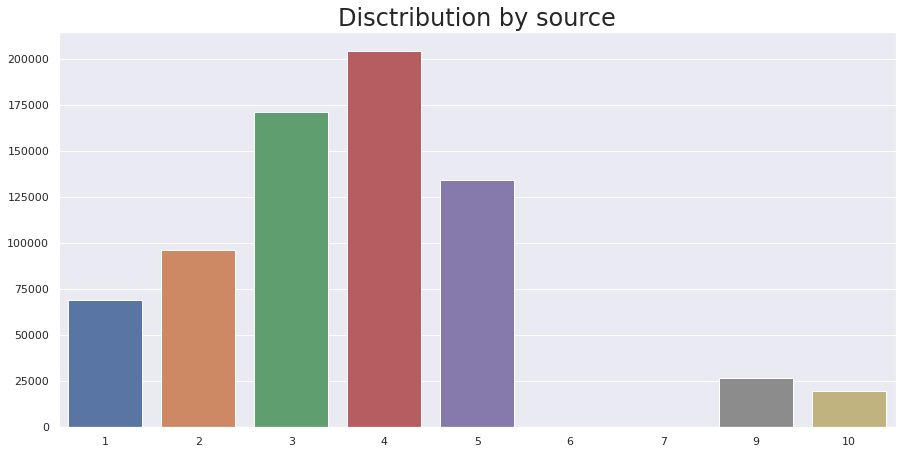

In [15]:
_ = visits['source_id'].value_counts()
ax = sns.barplot(_.index, _.values)
ax.set_title("Disctribution by source", size=24)

/home/magleb/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Disctribution by device')

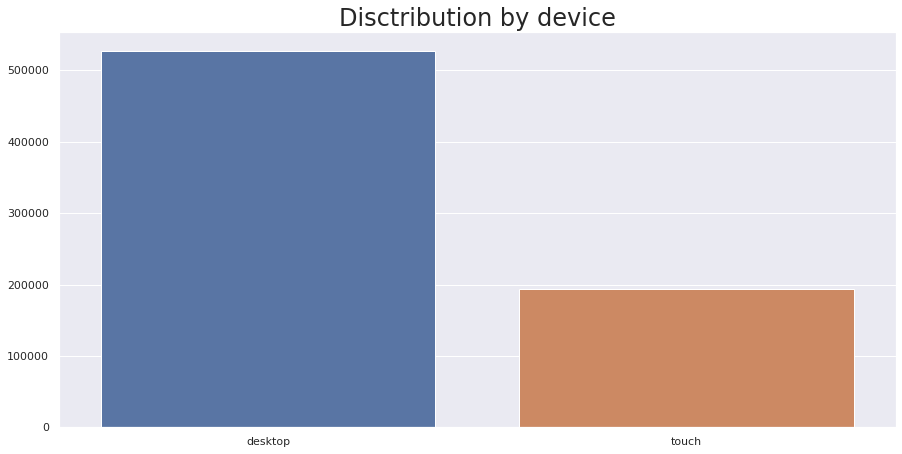

In [16]:
_ = visits['device'].value_counts()
ax = sns.barplot(_.index, _.values)
ax.set_title("Disctribution by device", size=24)

Text(0.5, 1.0, 'Distribution revenue')

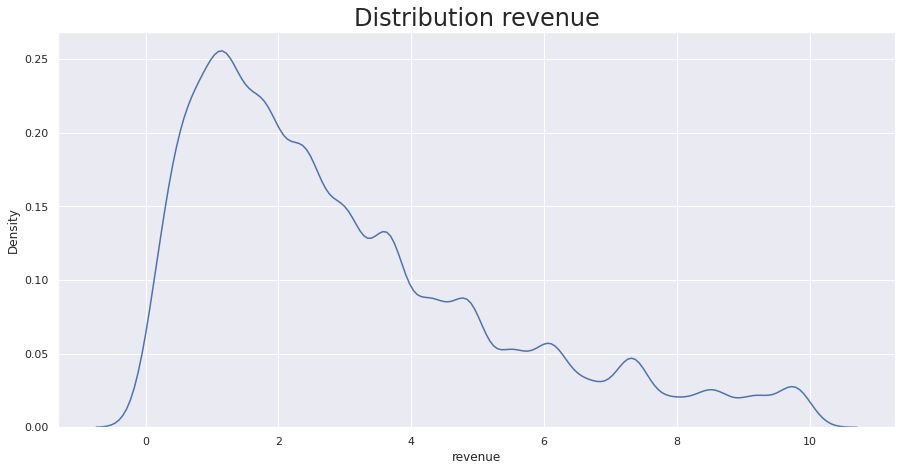

In [17]:
ax = sns.kdeplot(purchases[purchases['revenue'] < 10]['revenue'])
ax.set_title("Distribution revenue", size=24)

In [18]:
def timedelta_to_seconds(time: 'TimeDelta'):
    return time.days * 3600 * 60 + time.seconds 

In [19]:
visits['time_session'] = visits['end_ts'] - visits['start_ts']
visits['time_session_seconds'] = visits['time_session'].apply(timedelta_to_seconds)

In [20]:
visits['time_session_seconds'].describe()

count    720679.000000
mean        754.348986
std        1024.302610
min         101.000000
25%         191.000000
50%         395.000000
75%         943.000000
max       42749.000000
Name: time_session_seconds, dtype: float64

Text(0.5, 1.0, 'Distribution time session in seconds')

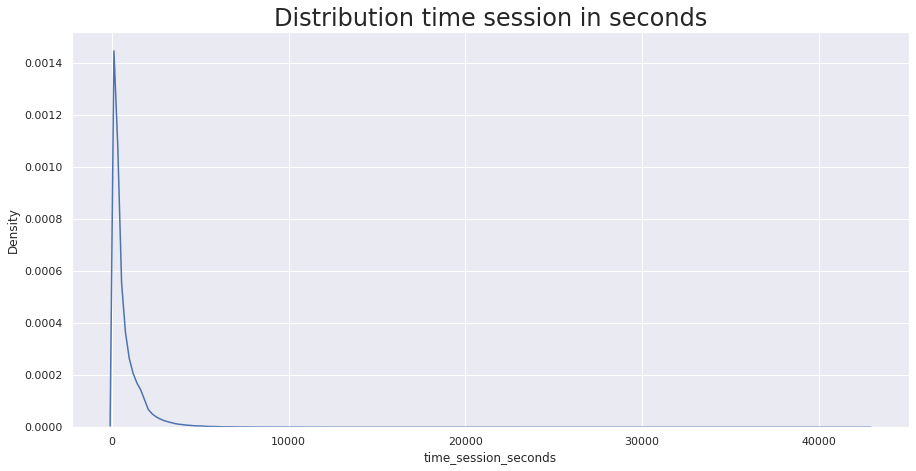

In [21]:
ax = sns.kdeplot(visits['time_session_seconds'])
ax.set_title("Distribution time session in seconds", size=24)

In [22]:
print('Median longest session: {:.2f} seconds'.format(visits['time_session_seconds'].median()))
print('Moda longest session: {} seconds'.format(visits['time_session_seconds'].mode()[0]))

Median longest session: 395.00 seconds
Moda longest session: 101 seconds


## 3. DAU, WAU, MAU + sessions for one user per day

In [23]:
visits['session_year']  = visits['start_ts'].values.astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].values.astype('datetime64[M]')
visits['session_week']  = visits['start_ts'].values.astype('datetime64[W]')
visits['session_date']  = visits['start_ts'].dt.date

In [24]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby('session_week').agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby('session_month').agg({'uid': 'nunique'}).mean()

In [25]:
print('DAU for all period of time:', int(dau_total), 'users')
print('WAU for all period of time:', int(wau_total), 'users')
print('MAU for all period of time:', int(mau_total), 'users')

DAU for all period of time: 1713 users
WAU for all period of time: 10463 users
MAU for all period of time: 41240 users


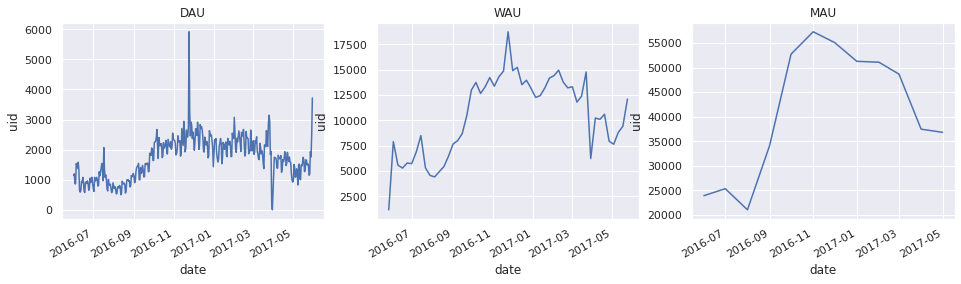

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(visits.groupby('session_date').agg({'uid': 'nunique'}))
ax[0].set(title = 'DAU', xlabel = 'date', ylabel = 'uid')
ax[1].plot(visits.groupby('session_week').agg({'uid': 'nunique'}))
ax[1].set(title = 'WAU', xlabel = 'date', ylabel = 'uid')
ax[2].plot(visits.groupby('session_month').agg({'uid': 'nunique'}))
ax[2].set(title = 'MAU', xlabel = 'date', ylabel = 'uid')
fig.autofmt_xdate(rotation=30)
plt.show()

In [27]:
sess_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
sess_per_user.columns = ['n_sessions', 'n_users']
sess_per_user['sess_per_user'] = sess_per_user['n_sessions'] / sess_per_user['n_users']

Text(0.5, 1.0, 'Count sessions for one user')

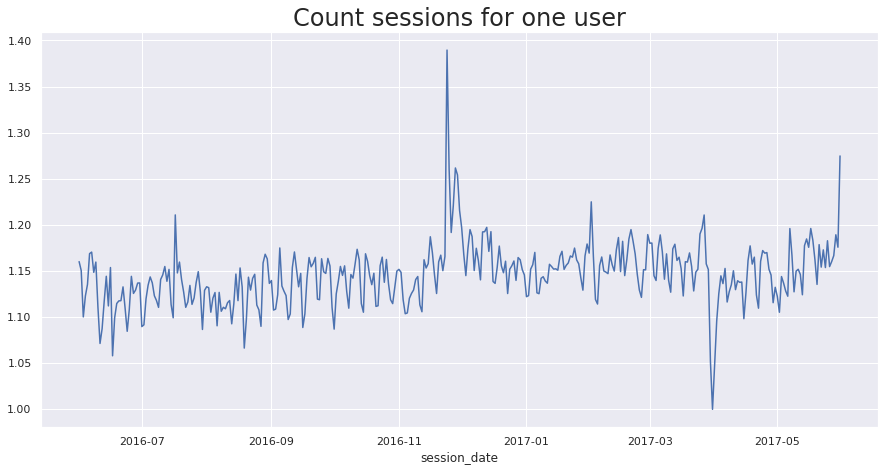

In [28]:
sess_per_user['sess_per_user'].plot().set_title('Count sessions for one user', size=24)

In [29]:
print('In median for one user {} sessions per day.'.format(round(sess_per_user['sess_per_user'].mean(),2)))

In median for one user 1.15 sessions per day.


## 4. How offen users return

In [30]:
first_visits = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'start_ts']
first_visits = first_visits.merge(visits[['uid', 'device', 'source_id', 'start_ts']], 
                                  on = ['uid', 'start_ts'])
first_visits.head()

,uid,start_ts,device,source_id
0,4245,2016-11-15 09:11:16,desktop,5
1,5097,2017-02-18 23:00:30,desktop,3
2,8896,2017-01-03 19:44:56,desktop,3
3,21017,2016-06-14 17:16:17,desktop,5
4,30696,2016-11-26 14:01:27,desktop,3


In [31]:
first_visits = first_visits.rename(columns={'start_ts': 'first_session_start_ts'})
first_visits['first_session_dt'] = first_visits['first_session_start_ts'].dt.date
first_visits['first_session_month'] = first_visits['first_session_start_ts'].astype('datetime64[M]')
first_visits.head()

,uid,first_session_start_ts,device,source_id,first_session_dt,first_session_month
0,4245,2016-11-15 09:11:16,desktop,5,2016-11-15,2016-11-01
1,5097,2017-02-18 23:00:30,desktop,3,2017-02-18,2017-02-01
2,8896,2017-01-03 19:44:56,desktop,3,2017-01-03,2017-01-01
3,21017,2016-06-14 17:16:17,desktop,5,2016-06-14,2016-06-01
4,30696,2016-11-26 14:01:27,desktop,3,2016-11-26,2016-11-01


In [32]:
vis = pd.merge(first_visits, visits, on = 'uid')

# считаем, сколько прошло времени между каждой сессией и первой сессией пользователя

vis['age_days'] = vis['session_date'] - vis['first_session_dt']
vis['age_months'] = ((vis['session_month'] - vis['first_session_month']) / np.timedelta64(1,'M')).round().astype('int')

In [33]:
cohorts = vis.pivot_table(index='first_session_month',
                  columns='age_months',
                  values='uid',
                  aggfunc='nunique')

In [34]:
retention = pd.DataFrame()
for col in cohorts.columns:
    retention = pd.concat([retention, cohorts[col]/cohorts[0]], axis=1)
retention.columns = cohorts.columns

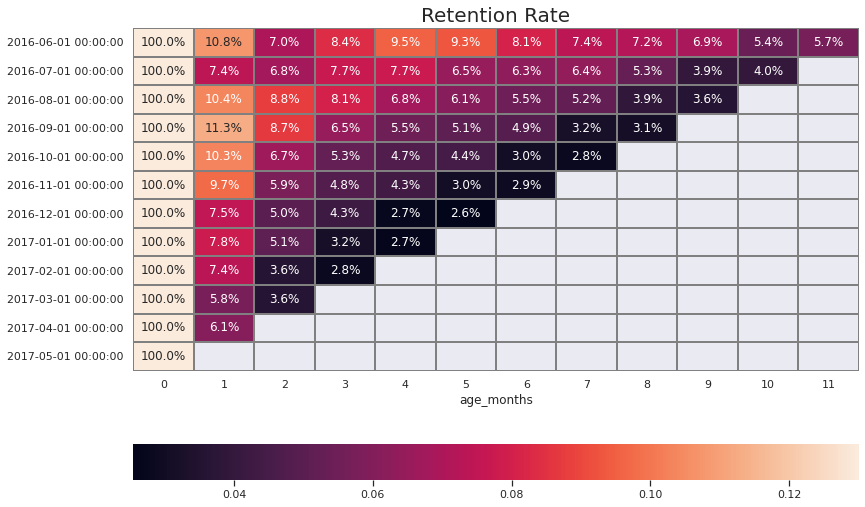

In [35]:
plt.figure(figsize=(13, 9))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='grey',  vmax=0.13, cbar_kws= {'orientation': 'horizontal'} 
            ).set_title('Retention Rate', size=20)
plt.show()

In [36]:
print('In median {0:.1%} users return for next month after first purchase.'.format(retention[1].mean())) 

In median 8.6% users return for next month after first purchase.


## 5. How much make purchase for half year?

In [37]:
purchases['order_dt']    = purchases['buy_ts'].dt.date
purchases['order_month'] = purchases['buy_ts'].astype('datetime64[M]')

In [38]:
purchases1 = purchases.join(visits
                     .sort_values(by='start_ts')
                     .groupby('uid')
                     .agg({'source_id': 'first',
                           'device': 'first', 
                           'start_ts': 'min'}),
                     on='uid', how='inner')

In [39]:
purchases1['first_session_month'] = purchases1['start_ts'].astype('datetime64[M]')

In [40]:
cohort_sizes = purchases1.groupby('first_session_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)
cohorts = purchases1.groupby(['first_session_month', 'order_month'])\
                 .agg({'revenue': ['sum', 'count']}).reset_index()

In [41]:
cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_session_month']) / np.timedelta64(1,'M')).round().astype('int')
cohorts.columns = ['first_session_month', 'order_month', 'revenue', 'n_orders', 'age_month']

In [42]:
cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_session_month')
cohorts_report['rev_per_buyer'] = cohorts_report['revenue'] / cohorts_report['n_buyers']
cohorts_report['orders_per_buyer'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']

In [43]:
cohorts_age = cohorts_report.pivot_table(
    index='first_session_month', 
    columns='age_month', 
    values=['orders_per_buyer'], 
    aggfunc='sum'
).cumsum(axis=1)

cohorts_age.columns= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

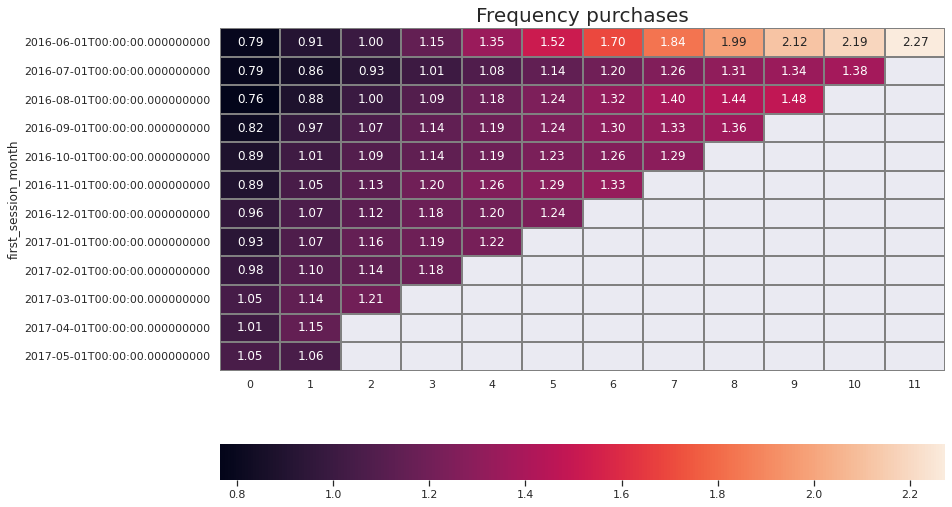

In [44]:
plt.figure(figsize=(13, 9))
sns.heatmap(cohorts_age, annot=True, fmt='.2f', linewidths=1, linecolor='grey', cbar_kws= {'orientation': 'horizontal'} 
            ).set_title('Frequency purchases', size=20)
plt.show()

In [45]:
print('For 6 months customer make {:.2f} purchases'.format(cohorts_age[5].mean()))

For 6 months customer make 1.27 purchases


## 6. LTV

In [46]:
cohorts_age = cohorts_report.pivot_table(
    index='first_session_month', 
    columns='age_month', 
    values='rev_per_buyer', 
    aggfunc='sum'
).cumsum(axis=1)

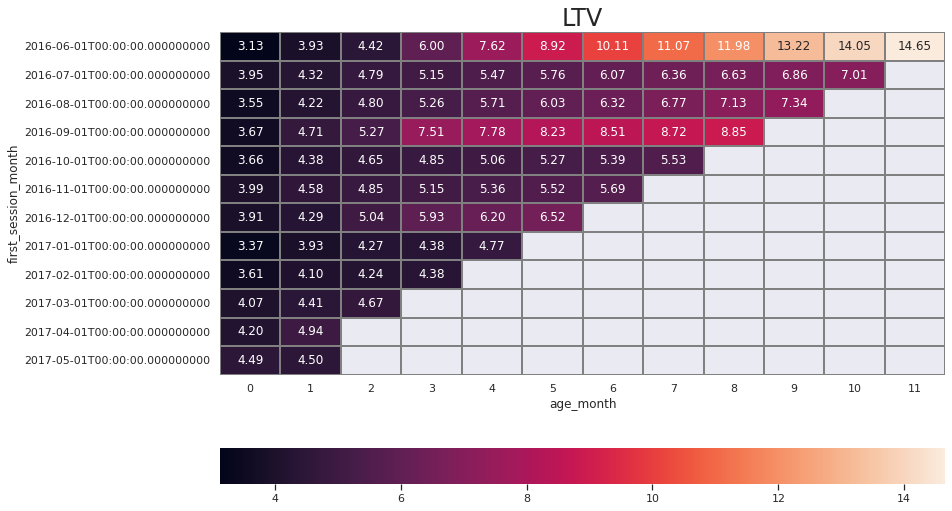

In [47]:
plt.figure(figsize=(13, 9))
sns.heatmap(cohorts_age, annot=True, fmt='.2f', linewidths=1, linecolor='grey', cbar_kws= {'orientation': 'horizontal'} 
            ).set_title('LTV', size=24)
plt.show()

In [48]:
print('LTV for 6 month after first purchase ${:.2f} '\
      .format(cohorts_age[5].mean()))

LTV for 6 month after first purchase $6.61 


In [49]:
first_orders = purchases.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')
first_orders['first_order_week'] = first_orders['first_order_ts'].astype('datetime64[W]')
first_orders.head()

,uid,first_order_ts,first_order_dt,first_order_month,first_order_week
0,157352,2016-06-23 13:08:21,2016-06-23,2016-06-01,2016-06-23
1,256370,2016-06-13 18:07:53,2016-06-13,2016-06-01,2016-06-09
2,308857,2016-06-23 09:07:29,2016-06-23,2016-06-01,2016-06-23
3,352142,2017-02-17 18:41:06,2017-02-17,2017-02-01,2017-02-16
4,445960,2016-10-19 13:28:03,2016-10-19,2016-10-01,2016-10-13


In [50]:
buyers = pd.merge(first_visits, first_orders, on='uid')

In [51]:
ltv = {}

for source, df in buyers.groupby('source_id'):
    cohort_sizes = df.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)

    cohorts = pd.merge(purchases, df, how='inner', on='uid')\
    .groupby(['first_order_month', 'order_month'])\
    .agg({'revenue': ['sum', 'count']}).reset_index()

    cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1,'M')).round()
    cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'n_orders', 'age_month']

    cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
    cohorts_report['rev_per_buyer'] = cohorts_report['revenue'] / cohorts_report['n_buyers']
    cohorts_report['orders_per_buyer'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']

    cohorts_age = cohorts_report.pivot_table(
        index='first_order_month', 
        columns='age_month', 
        values='rev_per_buyer', 
        aggfunc='sum'
    ).cumsum(axis=1)
    
    try:
        ltv[source] = cohorts_age[5].mean()
    except KeyError:
        pass
for i in ltv:
    print('For 6 months customer in median from source {} spend {:.2f} '.format(i, ltv[i]))

For 6 months customer in median from source 1 spend 11.48 
For 6 months customer in median from source 2 spend 17.01 
For 6 months customer in median from source 3 spend 5.64 
For 6 months customer in median from source 4 spend 6.25 
For 6 months customer in median from source 5 spend 8.44 
For 6 months customer in median from source 9 spend 5.79 
For 6 months customer in median from source 10 spend 3.73 
